# Note

The goal here is to take the output from AutoML & test feature impotances across multiple models. Then we can choose our model based on other factors like explainability, transparency & speed.  

Below we're using SHAP for feature evaluation, but there might be a better way.  

The main objectives here are:
- to programatically extract feature impotances across a broad array of models. 
- to compare those feature impotances to aid in the selection of features in the final model
- to generate visuals that help non-expert decision-makers understand basis of predictions. 




In [1]:
import pathlib
import pandas as pd
import sklearn
import shap
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import lightgbm as lgb


partitions = True

if partitions == True:
    print('partitions')
    all_files = [pathlib.Path.cwd() / 'partitions' / 'fms' / ('fm%s.dat' % str(i).zfill(2)) for i in range(0, 61)]
    df = pd.concat((pd.read_pickle(f, compression='gzip') for f in all_files) )  
else:
    print('no partitions')
    df = pd.read_pickle('es0.dat', compression='gzip')

df['fta'] = df['fta_x'].copy()
df.drop(columns=['fta_x', 'fta_y'], inplace=True)
holdout = df[df.index.str[:4] == '2019'].copy()
df = df[df.index.str[:4] != '2019'].copy()
X = df.reset_index(drop=True)
X = X.fillna(0)
X = X[X.describe().T.index].copy()
y = X.pop("fta")
for feature in X.columns:
    if 'fta' in feature:
        X.drop(labels=feature, axis=1, inplace=True)
for feature in X.columns:
    if '2019' in feature:
        X.drop(labels=feature, axis=1, inplace=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X.values, y.values, train_size=0.75, test_size=0.25
)

d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

imbalance = 1/y.mean()
print(imbalance)


partitions


/home/donald_braman_gmail_com/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


3.2101692682605547


# Start with LightGBM
It's quick and hard to beat, so a good place to start. 

Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.616694


/home/donald_braman_gmail_com/anaconda3/lib/python3.7/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


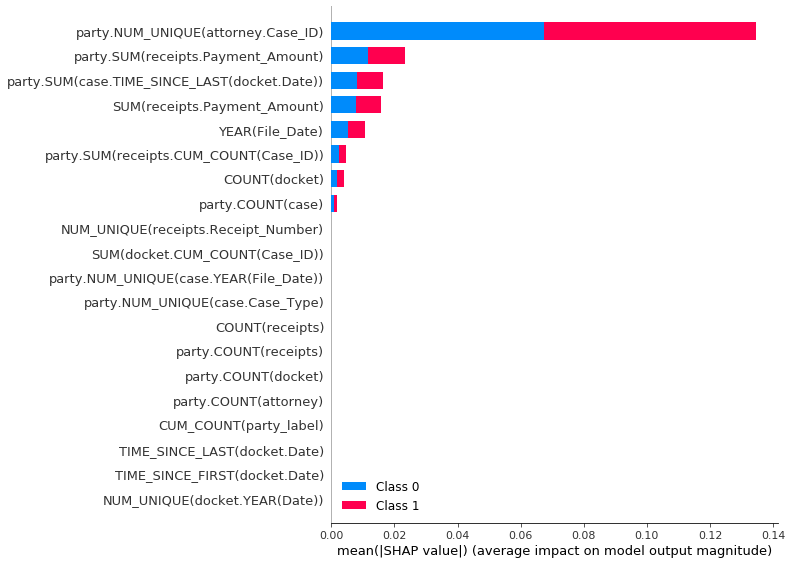

In [2]:

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
#     "is_unbalance": True,     # you can use one of these, but not both. 
    "scale_pos_weight": imbalance,   # you can use one of these, but not both.
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 100000, valid_sets=[d_test], early_stopping_rounds=500, verbose_eval=1000)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

# now with random forest
LightGBM is nice, but it's also not quite as transparent as rf.  
The downside to rf is that it is slow, and the tree explainer takes a while to run. 

In [5]:
X = df.sample(n=10000, random_state=42)
X = X.reset_index(drop=True)
X = X.fillna(0)
X = X[X.describe().T.index].copy()
y = X.pop("fta")
for feature in X.columns:
    if 'fta' in feature:
        X.drop(labels=feature, axis=1, inplace=True)
for feature in X.columns:
    if '2019' in feature:
        X.drop(labels=feature, axis=1, inplace=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X.values, y.values, train_size=0.75, test_size=0.25
)



/home/donald_braman_gmail_com/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


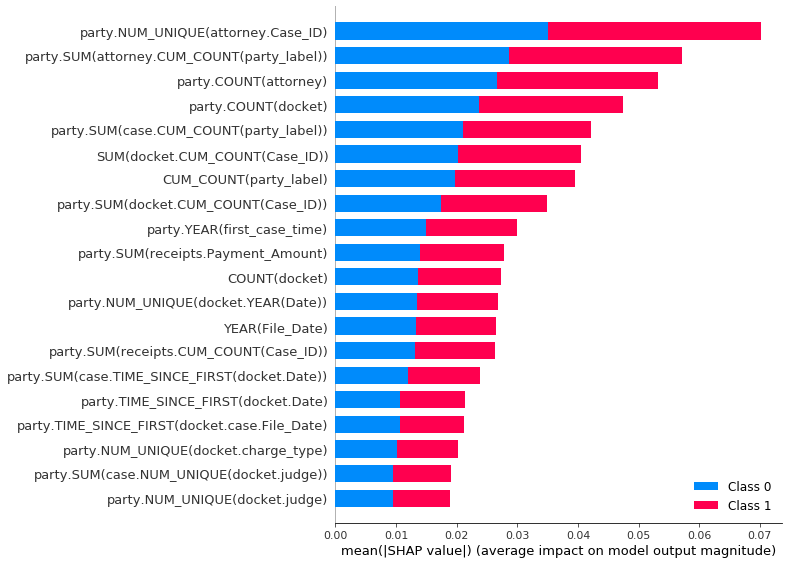

In [6]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
predicted = model.predict_proba(X_test)
shap_values = shap.TreeExplainer(model).shap_values(X_test)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)